In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
/kaggle/input/glove6b50dtxt/glove.6B.50d.txt
/kaggle/input/glove/__results__.html
/kaggle/input/glove/__notebook__.ipynb
/kaggle/input/glove/__output__.json
/kaggle/input/glove/custom.css
/kaggle/input/pretrained-model-on-ag-news-dataset/pytorch/default/1/model_AG NEWS small1.pth


## Importing Of Required Libraries 

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader 
from torch.nn.utils.rnn import pad_sequence 
from sklearn.model_selection import train_test_split
import peft
from peft import LoraConfig,get_peft_model,TaskType
from nltk.tokenize import wordpunct_tokenize
import time 
import tqdm 
import os 

2026-02-02 19:16:00.344899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770059760.534410      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770059760.589438      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770059761.035690      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770059761.035748      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770059761.035750      55 computation_placer.cc:177] computation placer alr

## Loading and Preprocessing of Data From The CSV Files

In [3]:
data=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
data["sentiment"] = data["sentiment"].map({
    "negative": 0,
    "positive": 1
})


In [5]:
data


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [6]:
class CSVDataset(Dataset):
    def __init__(self,dataframe):
        self.df=dataframe.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        review=self.df.iloc[idx]['review']
        label=torch.tensor(self.df.iloc[idx]['sentiment'],dtype=torch.long)
        return review,label


In [7]:
train_df,test_df=train_test_split(data,test_size=0.2,random_state=42)
train_dataset=CSVDataset(train_df)
test_dataset=CSVDataset(test_df)


## DataLoader + Collate Batching

In [8]:
train_dataloader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=32,shuffle=True)


In [9]:
reviews,labels=next(iter(train_dataloader))
print(reviews[0],labels[0])


The Revolt of the Zombies is not the worst movie I've ever seen, but it is pretty far down on the list. When an expedition is sent to Cambodia to discover the trick to making zombies after World War I, one of the members decides to use the knowledge for his own evil ambitions. And he succeeds, at least at first. A love triangle complicates the story some.<br /><br />This really was a tedious movie, with horrible acting that made it difficult to tell who were zombies and who weren't. The dialog was little better and the plot was unbelievable (not the zombie part of it but parts related to the "romance"). And while I am not any student or expert on cinematography, the camera work didn't seem to help the film much either.<br /><br />While I have seen a few movies that are worse, this is unlikely to please anyone. It's bad, and NOT in a so-bad-that-it-is-good kind of way. tensor(0)


In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("watts2/glove6b50dtxt")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/glove6b50dtxt


In [11]:
def load_glove_with_itos(file_path):
    stoi = {}
    itos = []  
    vectors = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            values = line.split()
            word = values[0]
            
            stoi[word] = i
            itos.append(word)  # word at index 'i'
            
            vector = np.asarray(values[1:], dtype='float32')
            vectors.append(vector)
            
    return stoi, itos, np.array(vectors)

# Usage
stoi, itos, vectors = load_glove_with_itos('/kaggle/input/glove6b50dtxt/glove.6B.50d.txt')



In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
vocab_size=len(stoi)
vocab_size


400000

In [14]:
def text_pipeline(x):
    tokens = wordpunct_tokenize(x.lower())
    return [stoi.get(token, stoi.get('<unk>', 0)) for token in tokens]


In [15]:
max_len=256
def collate_batch(batch):
    label_list=[]
    text_list=[]
    for _text,_label in  batch:
        label_list.append(_label)
        text_list.append(torch.tensor(text_pipeline(_text)[:max_len],dtype=torch.int64))
    label_list=torch.tensor(label_list,dtype=torch.int64)
    text_list=pad_sequence(text_list,batch_first=True)
    return label_list.to(device),text_list.to(device)


In [16]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)


In [17]:
label,sequence=next(iter(train_dataloader))
label,sequence


(tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
         0, 1, 1, 1, 1, 1, 1, 0], device='cuda:0'),
 tensor([[   41,  4223,    37,  ...,     0,     0,     0],
         [   41,  3316,    57,  ...,     0,     0,     0],
         [  192,  1095,     5,  ...,     1,    56, 16580],
         ...,
         [ 1481,     0,   254,  ...,     0,  2219,    14],
         [   20,    57,  1534,  ...,     0,     0,     0],
         [    8,    20,    40,  ...,     0,     0,     0]], device='cuda:0'))

### Pretrained Model Architecture

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


In [19]:
import math
class Net(nn.Module):
    def __init__(

        self,
        num_class,vocab_size,
        freeze=True,
        nhead=2,
        dim_feedforward=128,
        num_layers=2,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1):

        super().__init__()

        vector_tensor = torch.from_numpy(vectors).float() 
        self.emb = nn.Embedding.from_pretrained(vector_tensor, freeze=freeze)

        embedding_dim = self.emb.embedding_dim


        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            max_len=256
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [20]:
imdb_label={0:"negative",1:"positive"}


In [21]:
def predict(text, text_pipeline, model):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)
        model.to(device)
        output = model(text)
        return imdb_label[output.argmax(1).item()]


### Visualization Layer

In [22]:
def plot(cost,acc_epoch):
    fig,ax1=plt.subplots()
    ax1.plot(cost,color='red')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cross Entropy Loss')
    ax2=ax1.twinx()
    ax2.plot(acc_epoch,color='blue')
    ax2.set_ylabel('Accuracy')
    ax2.tick_params(axis='y', color='blue')
    fig.tight_layout()
    plt.show()


### Loading the Pretrained Model

In [81]:
model = Net(num_class=4,vocab_size=vocab_size).to(device)
state_dict = torch.load('/kaggle/input/pretrained-model-on-ag-news-dataset/pytorch/default/1/model_AG NEWS small1.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

### Updating Classifier Layer of Pretrained Model 

In [82]:
model.classifier=nn.Linear(model.classifier.in_features,2)

In [83]:
model

Net(
  (emb): Embedding(400000, 50)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=50, bias=True)
        (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=50, out_features=2, bias=True)
)

### Wrapping The model in a PEFT Trainable model

In [84]:
lora_config=LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["out_proj","linear1","linear2"],
    modules_to_save=["classifier"],
    bias='none'
)

In [85]:
model=get_peft_model(model,lora_config)

### Training The Model

In [86]:
from tqdm.auto import tqdm
def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for label, text in dataloader:
            label, text = label.to(device), text.to(device)
            output = model_eval(text)
            predicted = torch.max(output.data, 1)[1]
            total_acc += (predicted == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [87]:
def save_list_to_file(lst, filename):
    with open(filename + ".txt", "w") as f:
        for item in lst:
            f.write(f"{item}\n")


In [88]:
def train_model(model, optimizer, criterion, train_dataloader, test_dataloader,  epochs=1000, save_dir="", file_name=None):
    cum_loss_list = []
    acc_epoch = []
    acc_old = 0
    model_path = os.path.join(save_dir, file_name)
    acc_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_acc")
    loss_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_loss")
    time_start = time.time()

    for epoch in tqdm(range(1, epochs + 1),desc="Epochs", total=epochs):
        model.train()
        
        cum_loss = 0
        for idx, (label, text) in enumerate(train_dataloader):
            optimizer.zero_grad()
            label, text = label.to(device), text.to(device)

            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss += loss.item()
        print(f"Epoch {epoch}/{epochs} - Loss: {cum_loss}")

        cum_loss_list.append(cum_loss)
        accu_val = evaluate(test_dataloader,model)
        acc_epoch.append(accu_val)

        if model_path and accu_val > acc_old:
            print(accu_val)
            acc_old = accu_val
            if save_dir is not None:
                print("save model epoch",epoch)
                torch.save(model.state_dict(),model_path)
                save_list_to_file(lst=acc_epoch,filename=acc_dir)
                save_list_to_file(lst=cum_loss_list,filename=loss_dir)
                
    time_end = time.time()
    print(f"Training time: {time_end - time_start}")


In [89]:
model.to(device)

PeftModel(
  (base_model): LoraModel(
    (model): Net(
      (emb): Embedding(400000, 50)
      (pos_encoder): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-1): 2 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): lora.Linear(
                (base_layer): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=50, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=50, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict(

In [90]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = "/kaggle/working/"
file_name = "model_imdb_finetuned_lora.pth"
train_model(model=model, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, test_dataloader=test_dataloader,  epochs=100,  save_dir=save_dir ,file_name=file_name )


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 - Loss: 673.3098955750465
0.7828
save model epoch 1
Epoch 2/100 - Loss: 598.1118039041758
0.7914
save model epoch 2
Epoch 3/100 - Loss: 575.4301054477692
0.8072
save model epoch 3
Epoch 4/100 - Loss: 557.528269097209
0.8097
save model epoch 4
Epoch 5/100 - Loss: 547.468536183238
0.826
save model epoch 5
Epoch 6/100 - Loss: 539.5377030968666
0.8334
save model epoch 6
Epoch 7/100 - Loss: 533.414364695549
Epoch 8/100 - Loss: 530.5462917238474
Epoch 9/100 - Loss: 522.7683625668287
Epoch 10/100 - Loss: 519.0455029755831
Epoch 11/100 - Loss: 516.5909373164177
Epoch 12/100 - Loss: 513.6812096685171
0.837
save model epoch 12
Epoch 13/100 - Loss: 514.7115802913904
Epoch 14/100 - Loss: 511.4042781442404
Epoch 15/100 - Loss: 511.79284286499023
Epoch 16/100 - Loss: 509.001356318593
Epoch 17/100 - Loss: 509.3213500827551
Epoch 18/100 - Loss: 507.72263189405203
0.8391
save model epoch 18
Epoch 19/100 - Loss: 504.78527526557446
Epoch 20/100 - Loss: 502.4528396129608
Epoch 21/100 - Loss: 5

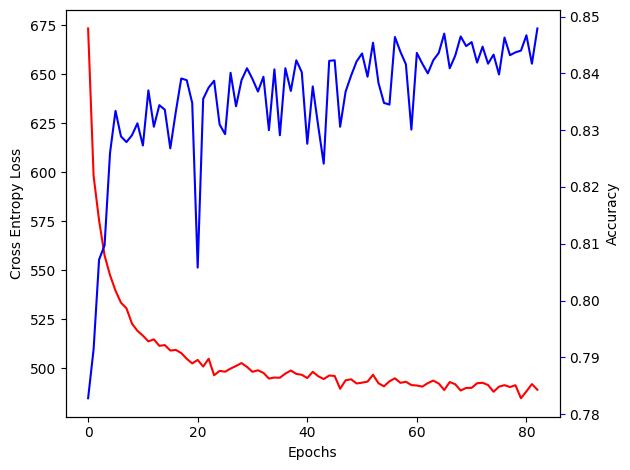

In [92]:
import matplotlib.pyplot as plt
def load_txt_to_list(filepath):
    with open(filepath, "r") as f:
        return [float(line.strip()) for line in f if line.strip()]

acc_epoch = load_txt_to_list("/kaggle/working/model_imdb_finetuned_lora_acc.txt")
cum_loss_list = load_txt_to_list("/kaggle/working/model_imdb_finetuned_lora_loss.txt")
plot(cum_loss_list,acc_epoch)
